# **<center> Xử lý ảnh và ứng dụng - CS406.M11 </center>**
## **<center> ĐỒ ÁN CUỐI Kì </center>**
## <center>KHẢO SÁT ĐỘ HIỆU QUẢ CỦA CÁC BIỆN PHÁP TĂNG CƯỜNG DỮ LIỆU CHO BÀI TOÁN PHÂN LOẠI BỆNH TRÊN LÁ CÂY TÁO</center>
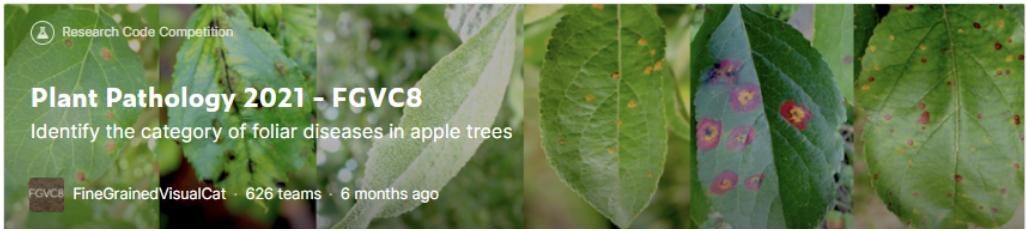
**I. Giới thiệu thành viên:**
  1. Phạm Quang Vinh - 19522398
  2. Huỳnh Đỗ Tấn Thành - 19522227

**II. Giảng viên hướng dẫn:**
  * TS. Mai Tiến Dũng

# **Import useful libraries**

---



In [ ]:
import math, os, re, warnings, random, glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import random
from tqdm import trange, tqdm

# **Set path:**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/data/apple_tree/train_images"

In [ ]:
dir_save_images_geo = "/content/drive/MyDrive/data/apple_tree/data_geometric/images"
dir_save_geo = "/content/drive/MyDrive/data/apple_tree/data_geometric"

In [ ]:
dir_save_images_art = "/content/drive/MyDrive/data/apple_tree/data_insect/images"
dir_save_art = "/content/drive/MyDrive/data/apple_tree/data_insect"

In [ ]:
dir_save_images_pixel = "/content/drive/MyDrive/data/apple_tree/data_pixel/images"
dir_save_pixel = "/content/drive/MyDrive/data/apple_tree/data_pixel"

In [ ]:
dir_save_images_full_aug = "/content/drive/MyDrive/apple_tree/data_full_augmentation/images"
dir_save_full_aug = "/content/drive/MyDrive/apple_tree/data_full_augmentation"

In [ ]:
lst_images = os.listdir(data_dir)
df = pd.read_csv("/content/drive/MyDrive/data/apple_tree/train.csv")

In [ ]:
len_image = len(lst_images)

In [ ]:
print(len_image)

18632


#**Augmentation**

---

In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=5,  main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [ ]:
def showimage(arr, title):
  plt.figure(figsize = (20, 20))
  n = len(arr)
  for i in range(n):
    plt.subplot(1, n, i+1)
    plt.title(title[i])
    img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2RGB)
    img = plt.imshow(img, interpolation = 'bicubic')

In [ ]:
chosen_image = cv2.imread("/content/drive/MyDrive/data/apple_tree/test_images/healthy/ad8770db05586b59.jpg")
chosen_image = cv2.cvtColor(chosen_image, cv2.COLOR_BGR2RGB)

##**Geometric Augmentaion**

In [ ]:
def geometric_augmentation(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    flag = False
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        flag = True
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
        flag = True
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
        flag = True
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90
        flag = True
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
        flag = True
    elif p_crop > .4:
        HEIGHT = image.shape[0]
        WIDTH = image.shape[1]
        crop_size_h = tf.random.uniform([], int(HEIGHT*.8), HEIGHT, dtype=tf.int32)
        crop_size_w = tf.random.uniform([], int(WIDTH*.8), WIDTH, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size_h, crop_size_w, 3])
        flag = True
    
    return image, flag

In [ ]:
temp = chosen_image.copy()

HEIGHT_temp = temp.shape[0]
WIDTH_temp = temp.shape[1]
crop_size_h = tf.random.uniform([], int(HEIGHT_temp*.8), HEIGHT_temp, dtype=tf.int32)
crop_size_w = tf.random.uniform([], int(WIDTH_temp*.8), WIDTH_temp, dtype=tf.int32)

tf_trans_list_geo = [
    tf.image.random_flip_left_right(temp),
    tf.image.random_flip_up_down(temp),
    tf.image.transpose(temp),
    tf.image.rot90(temp, k=3),
    tf.image.rot90(temp, k=2),
    tf.image.rot90(temp, k=1),
    tf.image.central_crop(temp, central_fraction=.7),
    tf.image.central_crop(temp, central_fraction=.8),
    tf.image.central_crop(temp, central_fraction=.9),
    tf.image.random_crop(temp, size=[crop_size_h, crop_size_w, 3])
]

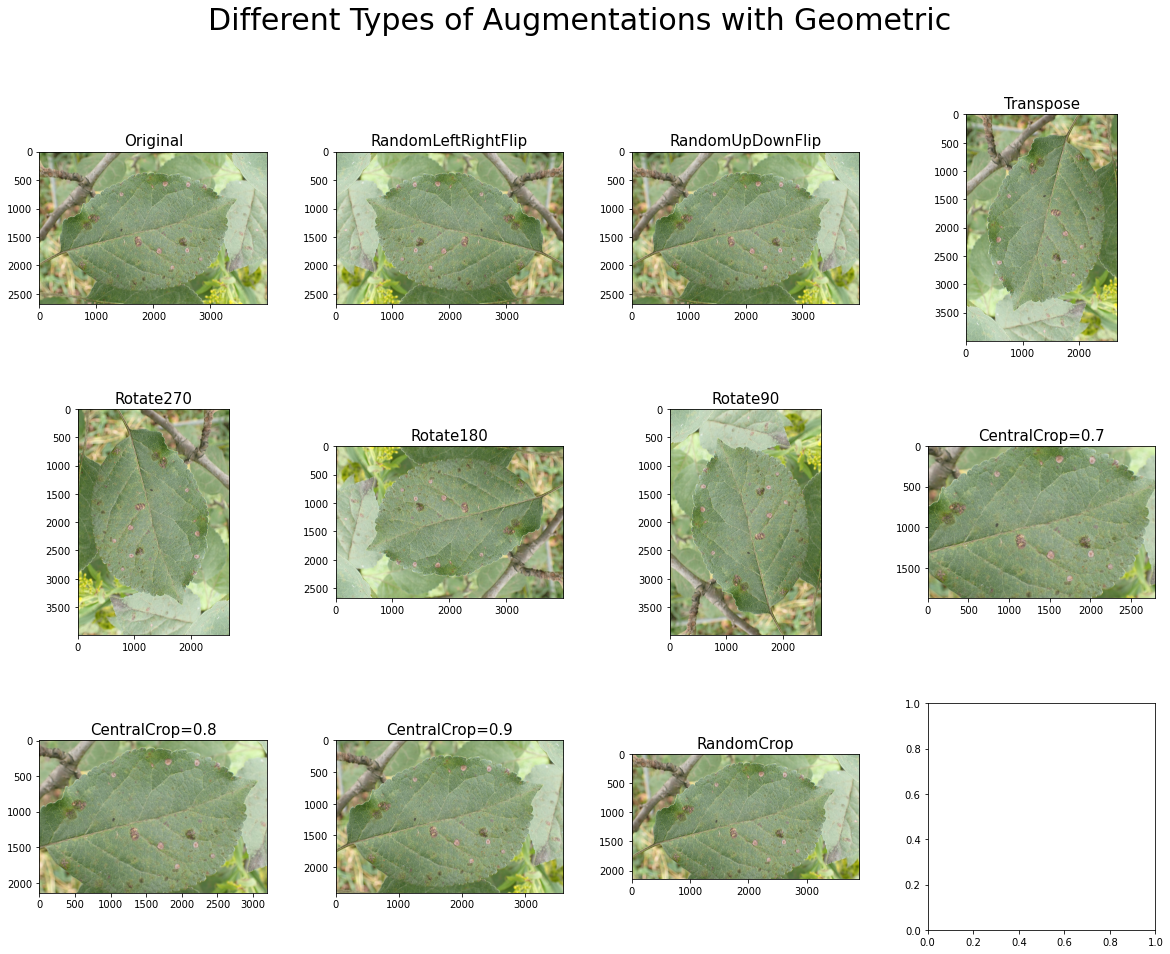

In [ ]:
img_matrix_list = []
bboxes_list = []
for aug_image in tf_trans_list_geo:
    img_matrix_list.append(aug_image)

img_matrix_list.insert(0, temp)    

titles_list = ["Original","RandomLeftRightFlip","RandomUpDownFlip","Transpose","Rotate270","Rotate180","Rotate90","CentralCrop=0.7","CentralCrop=0.8","CentralCrop=0.9","RandomCrop"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, nrows=3, main_title="Different Types of Augmentations with Geometric")

##**Pixel Augmentaion**

In [ ]:
def pixel_augmentation(image):
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    # Pixel-level transforms
    flag = False
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        flag = True
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        flag = True
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        flag = True
    
    return image, flag

In [ ]:
temp = chosen_image.copy()

tf_trans_list_pixel = [
    tf.image.random_saturation(temp, lower=.7, upper=1.3),
    tf.image.random_contrast(temp, lower=.8, upper=1.2),
    tf.image.random_brightness(temp, max_delta=.1)
]

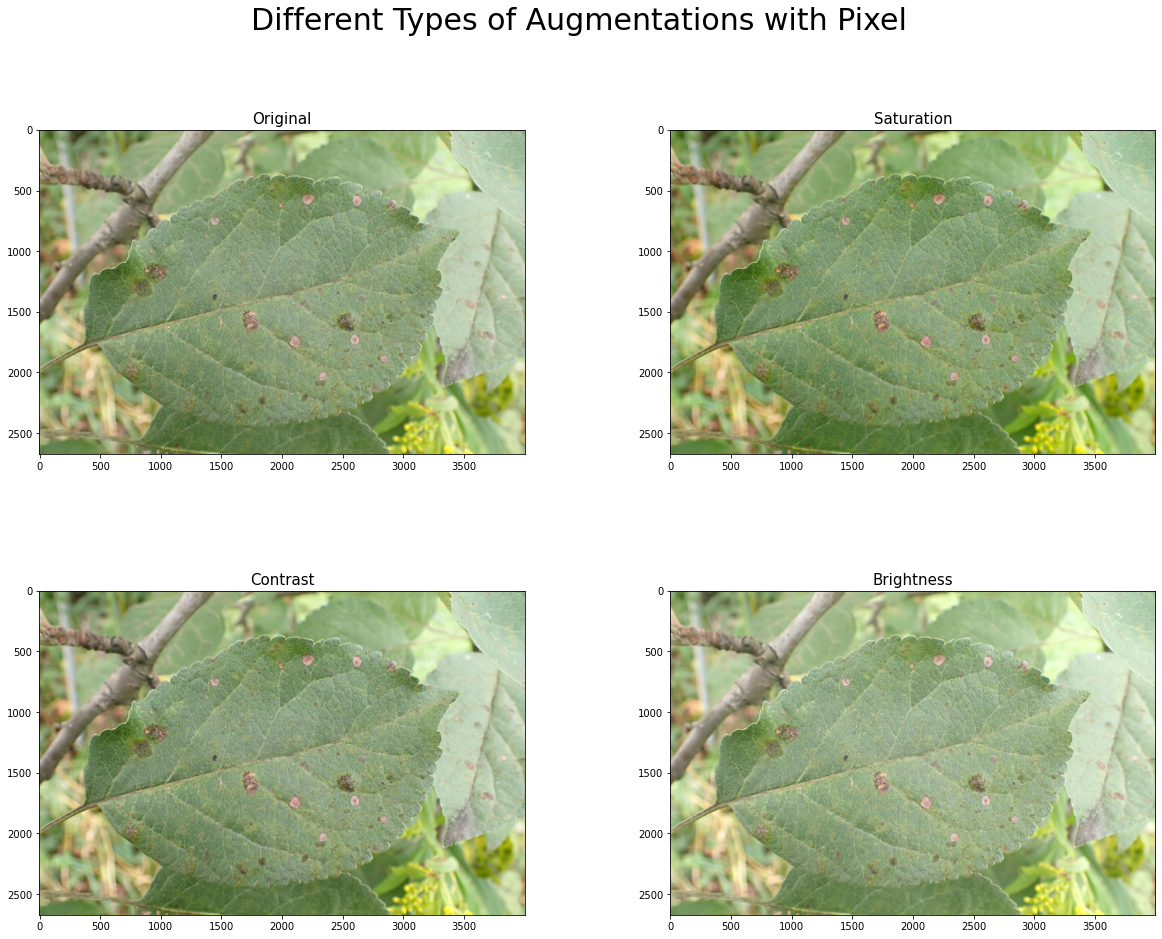

In [ ]:
img_matrix_list = []
bboxes_list = []
for aug_image in tf_trans_list_pixel:
    img_matrix_list.append(aug_image)

img_matrix_list.insert(0, temp)    

titles_list = ["Original","Saturation","Contrast","Brightness"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 2, nrows=2, main_title="Different Types of Augmentations with Pixel")

##**Artifact Augmentation**

In [ ]:
def artifact_augmentation(image, n_insects = 2, dark_insect=False, p = 0.5, insects_folder='/content/drive/MyDrive/data/apple_tree/insect'):
    aug_prob = random.random()
    flag = False
    if aug_prob < p:
        flag = True
        height, width, _ = image.shape  # target image width and height
        insects_images = os.listdir(insects_folder)
        img_shape = image.shape

        for _ in range(n_insects):
            insect = cv2.imread(os.path.join(insects_folder, random.choice(insects_images)))
            insect = cv2.flip(insect, random.choice([-1, 0, 1]))
            insect = cv2.rotate(insect, random.choice([0, 1, 2]))
            insect = cv2.resize(insect, (width, height))

            h_height, h_width, _ = insect.shape  # insect image width and height
            roi_ho = random.randint(0, image.shape[0] - insect.shape[0])
            roi_wo = random.randint(0, image.shape[1] - insect.shape[1])
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask 
            img2gray = cv2.cvtColor(insect, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            #mask_inv = cv2.cvtColor(cv2.bitwise_not(mask),cv2.COLOR_BGR2GRAY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of insect in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of insect from insect image.
            if dark_insect:
                img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                insect_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            else:
                insect_fg = cv2.bitwise_and(insect, insect, mask=mask)

            # Put insect in ROI and modify the target image
            dst = cv2.add(img_bg, insect_fg, dtype = cv2.CV_64F)

            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst


    return image, flag

##**Full Augmentaion**

In [ ]:
def data_full_augmentation(image):
    
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    flag = False

    # Insect
    n = random.randint(1, 2)
    image, flag = artifact_augmentation(image, n_insects = n, dark_insect=False, p = 0.2)

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        flag = True
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        flag = True
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        flag = True


    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        flag = True
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
        flag = True
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
        flag = True
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90
        flag = True
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
        flag = True
    elif p_crop > .4:
        HEIGHT = image.shape[0]
        WIDTH = image.shape[1]
        crop_size_h = tf.random.uniform([], int(HEIGHT*.8), HEIGHT, dtype=tf.int32)
        crop_size_w = tf.random.uniform([], int(WIDTH*.8), WIDTH, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size_h, crop_size_w, 3])
        flag = True
    
    return image, flag

# **Test**

---

In [ ]:
image_path = "/content/drive/MyDrive/data/apple_tree/test_images/healthy/ad8770db05586b59.jpg"
chosen_image = cv2.imread(image_path)

##**Geometric**

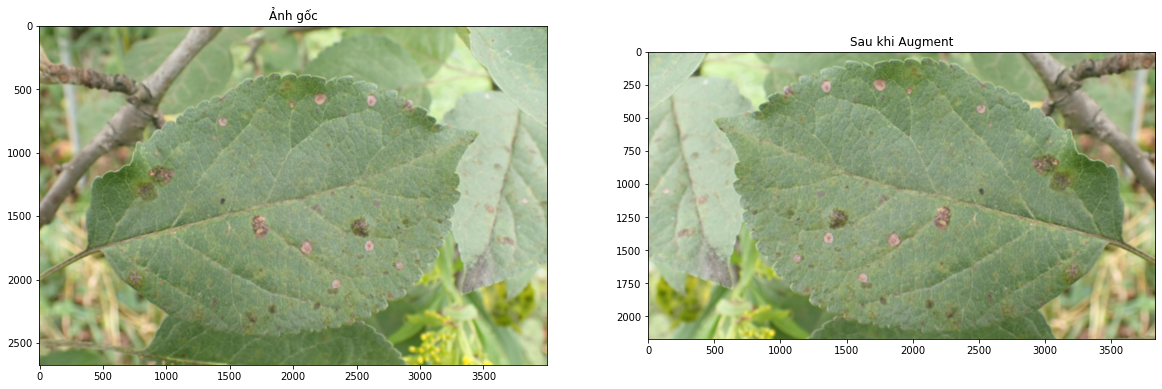

In [ ]:
temp = chosen_image.copy()
aug_image, flag = geometric_augmentation(temp)
aug_image = np.array(aug_image)
showimage([chosen_image, aug_image], ['Ảnh gốc', 'Sau khi Augment'])

##**Pixel**

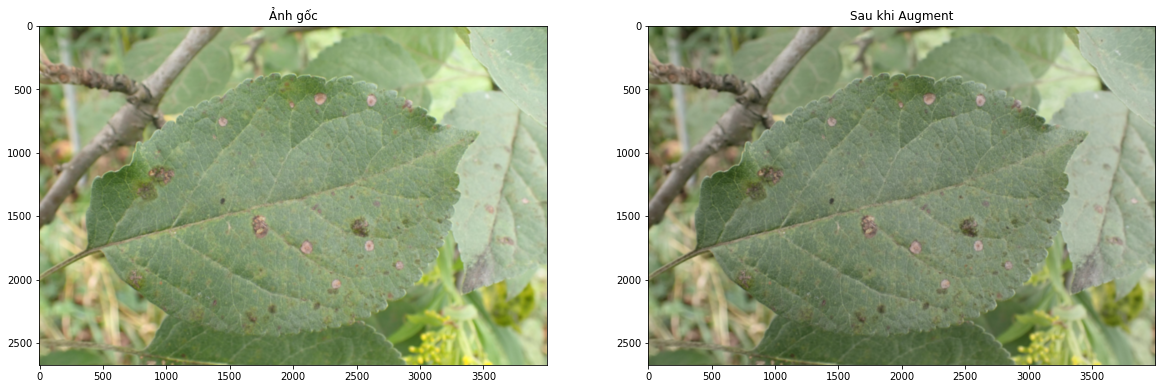

In [ ]:
temp = chosen_image.copy()
aug_image, flag = pixel_augmentation(temp)
aug_image = np.array(aug_image)
showimage([chosen_image, aug_image], ['Ảnh gốc', 'Sau khi Augment'])

##**Artifact**

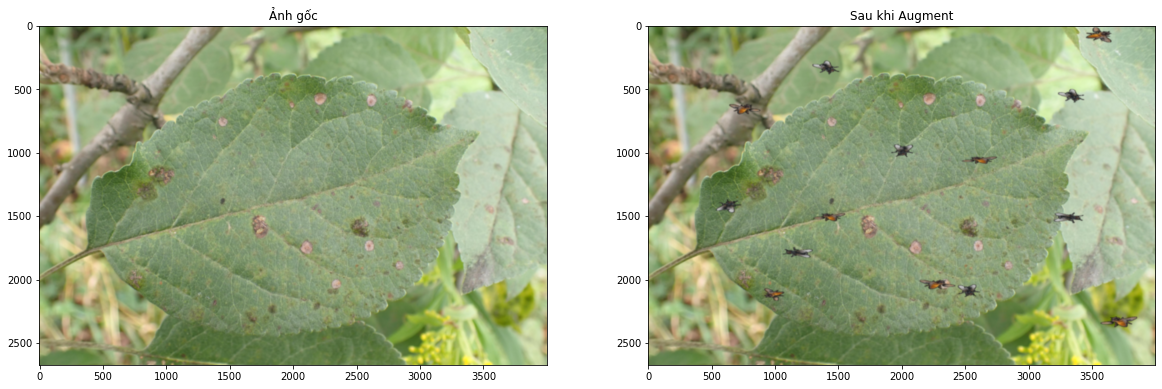

In [ ]:
temp = chosen_image.copy()
aug_image, flag = artifact_augmentation(temp, n_insects=2, dark_insect=False, p=1.0)
showimage([chosen_image, aug_image], ['Ảnh gốc', 'Sau khi Augment'])

##**Full**

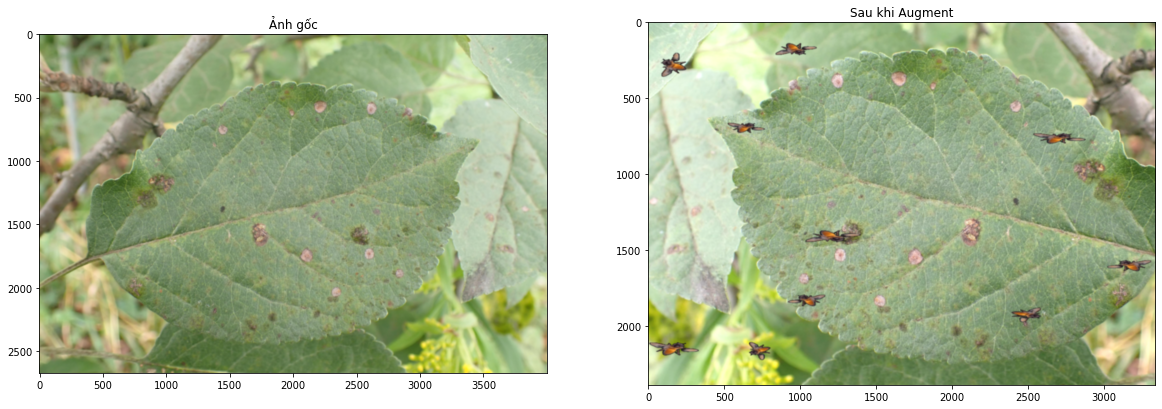

In [ ]:
temp = chosen_image.copy()
aug_image, flag = data_full_augmentation(temp)
aug_image = np.array(aug_image)
showimage([chosen_image, aug_image], ['Ảnh gốc', 'Sau khi Augment'])

#**Save Image**

---

## **Geometric**

In [ ]:
for name in tdqm(lst_images):
  img = cv2.imread(os.path.join(data_dir, name))
  shutil.copy(os.path.join(data_dir, name),os.path.join(dir_save_images_geo, name))
  label = df.loc[df["image"] == name, "labels"].tolist()[0]
  image, flag = geometric_augmentation(img)
  if flag:
    new = name.replace(".jpg", "")+"_aug.jpg"
    tf.keras.utils.save_img(os.path.join(dir_save_images_geo, new), image)

##**Pixel**

In [ ]:
for name in tdqm(lst_images):
  img = cv2.imread(os.path.join(data_dir, name))
  shutil.copy(os.path.join(data_dir, name),os.path.join(dir_save_images_pixel, name))
  label = df.loc[df["image"] == name, "labels"].tolist()[0]
  image, flag = pixel_augmentation(img)
  if flag:
    new = name.replace(".jpg", "")+"_aug.jpg"
    tf.keras.utils.save_img(os.path.join(dir_save_images_pixel, new), image)

##**Artifact**

In [ ]:
for name in tdqm(lst_images):
  img = cv2.imread(os.path.join(data_dir, name))
  shutil.copy(os.path.join(data_dir, name),os.path.join(dir_save_images_art, name))
  label = df.loc[df["image"] == name, "labels"].tolist()[0]
  n = random.randint(1, 2)
  image, flag = artifact_augmentation(img, n_insects = n, dark_insect=False, p = 0.2)
  if flag:
    new = name.replace(".jpg", "")+"_aug.jpg"
    cv2.imwrite(os.path.join(dir_save_images_art, new), image)

## **Full Augmentation**

In [ ]:
for i in trange(len_image):
  img = cv2.imread(os.path.join(data_dir, lst_images[i]))
  shutil.copy(os.path.join(data_dir, lst_images[i]),os.path.join(dir_save_images_full_aug, lst_images[i]))
  label = df_full.loc[df_full["image"] == lst_images[i], "labels"].tolist()[0]
  image, flag = data_full_augmentation(img)
  if flag:
    new = lst_images[i].replace(".jpg", "")+"_aug.jpg"
    tf.keras.utils.save_img(os.path.join(dir_save_images_full_aug, new), image)
    df_full.append({'image': new, 'labels': label}, ignore_index=True)

100%|██████████| 18632/18632 [9:45:22<00:00,  1.89s/it]
